In [1]:
import torch as t
from torchvision import models
from plant_pathology_dataset import PlantPathologyDataset
from torchvision import transforms
import os.path as path
import consts
import torch.utils.data as td
from training_meta import restore_image
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
vgg16 = models.vgg16(pretrained=True)

In [3]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

From the above output it is clear that first I'll have to replace the last linear layer, i.e., `vgg16.classifier[6]` with another linear layer that has 4 outputs (i.e., `out_features`) instead of 1000.

After that I can decide to unfreeze all the learnable layers in the classifer, i.e., `vgg16.classifier[0]` and `vgg16.classifier[3]`.

Beyond this it will not make much sense to unfreeze the `features` part of the model given the small amount of data that I have.

In [4]:
imgroot = path.join(consts.DATAROOT, "cache", "250x250")
means = (0.4038582976214318, 0.5127894672998029, 0.3129764558236694)
stds = (0.2034616086724042, 0.18909514150453344, 0.18761408366900625)
xform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])
ds = PlantPathologyDataset(imgroot, xform)

In [5]:
train_size = int(len(ds) * 0.9)
val_size = len(ds) - train_size
print(train_size, val_size)

1638 183


In [6]:
trainset, valset = td.random_split(ds, (train_size, val_size))
print(len(trainset), len(valset))

1638 183


Verify that the valset contains all four classes.

In [7]:
mask = [False, False, False, False]
for image, target in valset:
    mask[target] = True
    if mask == [True, True, True, True]:
        print("All good")
        break

All good


In [8]:
vgg16 = models.vgg16(pretrained=True)

# First freeze all the params
for param in vgg16.parameters():
    param.requires_grad = False

# Replace the last linear layer. This will automatically unfreeze it
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = t.nn.Linear(in_features, consts.NUM_CLASSES)

for param in vgg16.classifier.parameters():
    print(param.shape, param.requires_grad)

torch.Size([4096, 25088]) False
torch.Size([4096]) False
torch.Size([4096, 4096]) False
torch.Size([4096]) False
torch.Size([4, 4096]) True
torch.Size([4]) True


## Wire Check

In [9]:
dl = td.DataLoader(trainset, batch_size=16, shuffle=True)

If all the labels are not represented in the targets, then AUC metric will throw an errors. Continue until I get a batch with all 4 classes showing up in the targets.

In [10]:
for images, targets in dl:
    if targets.unique().shape[0] == 4:
        break
targets

tensor([3, 0, 0, 1, 0, 2, 0, 2, 1, 0, 3, 0, 2, 1, 0, 2])

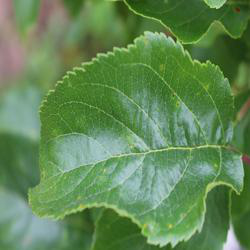

In [11]:
restore_image(images[0], means, stds)

In [12]:
consts.LABELS[targets[0].item()]

'multiple_diseases'

In [13]:
preds = vgg16(images)

In [14]:
print(preds.shape, preds.dtype)
preds

torch.Size([16, 4]) torch.float32


tensor([[ 0.1586,  0.0174,  0.1339,  0.6208],
        [-0.4919,  0.1409,  0.5143,  0.2292],
        [-0.7605, -0.2346,  0.7195, -0.0464],
        [-0.5398,  0.8743,  0.4270, -0.1717],
        [-0.1938,  0.2216,  0.3072,  0.1194],
        [ 0.1357,  1.0277,  0.4746,  0.4933],
        [ 0.1288,  0.2511,  0.2047,  0.0379],
        [-0.6049,  1.2207, -0.5729,  0.6748],
        [-0.3455,  0.6046,  0.5173, -0.3286],
        [ 0.6595,  0.5790,  0.8608,  0.2887],
        [ 0.3133,  0.3418,  0.2848,  0.1792],
        [-0.5173,  1.0197, -0.2211, -1.0806],
        [ 0.4168,  0.9739, -0.2197, -0.5800],
        [-0.2834, -0.0869,  0.5406,  0.8023],
        [-0.1758, -0.8572, -0.2348,  0.1175],
        [ 0.2901,  0.6483,  0.1093, -0.1628]], grad_fn=<AddmmBackward>)

In [15]:
preds = preds.detach()
loss = t.nn.CrossEntropyLoss()(preds, targets)
print(loss)

tensor(1.6005)


In [16]:
softmax = t.nn.Softmax()

In [17]:
probs = softmax(preds)
probs

tensor([[0.2257, 0.1959, 0.2202, 0.3582],
        [0.1303, 0.2453, 0.3564, 0.2680],
        [0.1096, 0.1854, 0.4813, 0.2238],
        [0.1088, 0.4477, 0.2862, 0.1573],
        [0.1807, 0.2738, 0.2983, 0.2472],
        [0.1594, 0.3890, 0.2237, 0.2279],
        [0.2426, 0.2742, 0.2617, 0.2215],
        [0.0845, 0.5244, 0.0872, 0.3038],
        [0.1434, 0.3709, 0.3399, 0.1459],
        [0.2607, 0.2405, 0.3188, 0.1799],
        [0.2581, 0.2655, 0.2508, 0.2257],
        [0.1322, 0.6148, 0.1778, 0.0753],
        [0.2744, 0.4791, 0.1452, 0.1013],
        [0.1341, 0.1632, 0.3056, 0.3971],
        [0.2639, 0.1335, 0.2488, 0.3538],
        [0.2563, 0.3668, 0.2139, 0.1630]])

In [18]:
roc_auc_score(targets, probs, multi_class='ovr')

0.4622825091575091

## Trainer

In [32]:
from torchutils import Hyperparams, Trainer, TrainerArgs
from dataclasses import dataclass
from haikunator import Haikunator
from torchutils.ml_loggers.csv_logger import CsvMLExperiment

In [20]:
softmax = t.nn.Softmax()
h = Haikunator()

In [21]:
@dataclass
class MyHyperparams(Hyperparams):
    batch_size: int
    n_epochs: int
    lr: float

In [22]:
def avg_auc(targets, preds):    
    probs = softmax(preds)
    return roc_auc_score(targets, probs, multi_class='ovr')

In [23]:
def build_model():
    vgg16 = models.vgg16(pretrained=True)

    # First freeze all the params
    for param in vgg16.parameters():
        param.requires_grad = False

    # Replace the last linear layer. This will automatically unfreeze it
    in_features = vgg16.classifier[6].in_features
    vgg16.classifier[6] = t.nn.Linear(in_features, consts.NUM_CLASSES)

    return vgg16

In [24]:
def build_trainer(hparams, trainset, valset):
    run_name = h.haikunate()
    print(f"Starting run {run_name}")
    
    model = build_model()
    # parameters = chain(model.classifier[3].parameters(), model.classifier[6].parameters())
    parameters = model.classifier[6].parameters()
    optim = t.optim.Adam(parameters, lr=hparams.lr)
    loss_fn = t.nn.CrossEntropyLoss()
    
    traindl = td.DataLoader(trainset, batch_size=hparams.batch_size, shuffle=True)
    valdl = td.DataLoader(valset, batch_size=100)
    
    return TrainerArgs(
        run_name=run_name,
        model=model,
        optimizer=optim,
        loss_fn=loss_fn,
        trainloader=traindl,
        valloader=valdl,
        n_epochs=hparams.n_epochs
    )

In [33]:
hparams = MyHyperparams(n_epochs=10, lr=0.001, batch_size=32)
exp = CsvMLExperiment("plant-pathology", consts.EXPROOT, stdout=True)
trainer = Trainer(exp, trainset, valset, [avg_auc])
trainer.metrics_log_frequency = 1  # Log every epoch's metrics
trainer.params_log_frequency = 5  # Log every 5th epoch's parameter histogram
trainer.model_log_frequency = 10000  # Don't save the model ever
trainer.train(hparams, build_trainer)

/Users/avilayparekh/temp/experiments/plant-pathology already exists. Will add runs to the existing experiment.
Starting run soft-hat-3938

Step 1
	train_loss = 0.912
	train_avg_auc = 0.790
	val_loss = 0.782
	val_avg_auc = 0.834

Step 2
	train_loss = 0.702
	train_avg_auc = 0.867
	val_loss = 0.741
	val_avg_auc = 0.872

Step 3
	train_loss = 0.640
	train_avg_auc = 0.898
	val_loss = 0.693
	val_avg_auc = 0.877

Step 4
	train_loss = 0.616
	train_avg_auc = 0.906
	val_loss = 0.715
	val_avg_auc = 0.874

Step 5
	train_loss = 0.587
	train_avg_auc = 0.909
	val_loss = 0.650
	val_avg_auc = 0.887
[WARN] Stdout does not support logging parameters

Step 6
	train_loss = 0.573
	train_avg_auc = 0.917
	val_loss = 0.650
	val_avg_auc = 0.888

Step 7
	train_loss = 0.567
	train_avg_auc = 0.927
	val_loss = 0.659
	val_avg_auc = 0.886

Step 8
	train_loss = 0.557
	train_avg_auc = 0.923
	val_loss = 0.637
	val_avg_auc = 0.893

Step 9
	train_loss = 0.531
	train_avg_auc = 0.933
	val_loss = 0.630
	val_avg_auc = 0.893

S

In [42]:
import pandas as pd
from PIL import Image

In [38]:
testset = pd.read_csv(path.join(consts.DATAROOT, "test.csv"))

In [48]:
trainer.model.eval()
with open("./baseline_submission.csv", "wt") as f:
    print("image_id,healthy,multiple_diseases,rust,scab", file=f)
    for row in testset.itertuples():
        img_file = f"{row.image_id}.jpg"
        img_path = path.join(imgroot, img_file)
        img = Image.open(img_path)
        img = xform(img)
        img = t.unsqueeze(img, 0)
        logits = trainer.model(img)[0]
        probs = softmax(logits)
        healthy = probs[consts.HEALTHY]
        multiple_diseases = probs[consts.MULTIPLE_DISEASES]
        rust = probs[consts.RUST]
        scab = probs[consts.SCAB]
        print(f"{row.image_id},{healthy:.3f},{multiple_diseases:.3f},{rust:.3f},{scab:.3f}", file=f)


image_id,healthy,multiple_diseases,rust,scab


In [49]:
t.save(trainer.model, "./models/baseline_model.pkl")